# **Imports**

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from PIL import Image
import pandas as pd
import cv2
import io

# **IDs and Data-Path**

In [32]:
ID_left = 'C6:22:F2:44:38:49'
ID_right = 'FE:F7:D0:12:2E:8D'

data_file_name = 'pt_2024-02-22 13:32:51.163741.csv'
data_file_path = '../Data/'

left_image_name = 'shoe_outline_left_with_sensors.png'
right_image_name = 'shoe_outline_right_with_sensors.png'
image_path = '../Images/'

output_path = '../Output/'

full_data_path = data_file_path + data_file_name
full_image_path_left = image_path + left_image_name
full_image_path_right = image_path + right_image_name

# **Data Pruning**

In [33]:
def parse_data_string(data_string):
    values = data_string.replace('PS: [', '').replace(']', '').split(',')
    data_array = np.array([np.abs(float(x)) for x in values] + [0.0, 0.0, 0.0, 0.0])
    return data_array

In [34]:
shoe_outline_right = Image.open(full_image_path_right)
shoe_outline_left = Image.open(full_image_path_left)

df = pd.read_csv(full_data_path)

df_filtered = df[df['data'].str.contains("PS: \[.*\]")].copy()

df_filtered.loc[:, 'data_array'] = df_filtered['data'].apply(parse_data_string)

df_right = df_filtered[df_filtered['deviceID'] == ID_right]
df_left = df_filtered[df_filtered['deviceID'] == ID_left]

len_right = len(df_right)
len_left = len(df_left)

if len_right > len_left:
    df_right = df_right[:len_left]

elif len_left > len_right:
    df_left = df_left[:len_right]

df_left = df_left.rename(columns={'data_array': 'data_array_left'})
df_right = df_right.rename(columns={'data_array': 'data_array_right'})

df_left = df_left.reset_index(drop=True)
df_right = df_right.reset_index(drop=True)

combined_data_array = pd.concat([df_left['data_array_left'], df_right['data_array_right']], axis=1)
combined_data_array = combined_data_array.applymap(lambda x: [abs(i) for i in x])

max_value = max(combined_data_array.values.flatten().max())

# **Region settup and sensor locations**

In [35]:
sensor_locations_pixels_left = np.array([(145, 513), (200, 200), (195, 78), (135, 190), 
                                        (83, 508), (85, 345), (65, 213), (103, 93)])


roi_left, roi_top, roi_right, roi_bottom = (0, 0, shoe_outline_left.width, shoe_outline_left.height)

x_grid_roi = np.linspace(roi_left, roi_right, 100)
y_grid_roi = np.linspace(roi_top, roi_bottom, 100)
x_mesh_roi, y_mesh_roi = np.meshgrid(x_grid_roi, y_grid_roi)

sensor_locations_pixels_left[:, 1] = roi_bottom - sensor_locations_pixels_left[:, 1]

corners = [(roi_left, roi_top), (roi_left, roi_bottom), (roi_right, roi_top), (roi_right, roi_bottom)]
corners = np.array([(x, roi_bottom - y) for x, y in corners])  


x_min = min(sensor_locations_pixels_left[:, 0])
x_max = max(sensor_locations_pixels_left[:, 0])

x_range = x_max - x_min
x_min_new = x_min - x_range
x_max_new = x_max + x_range

corners[:, 0] = np.array([x_min_new, x_min_new, x_max_new, x_max_new])

sensor_locations_pixels_left = np.concatenate([sensor_locations_pixels_left, corners])

In [36]:
sensor_locations_pixels_right = np.array([(182, 510), (180, 345), (200, 213), (161, 92), (135, 185), 
                                        (120, 515), (65, 200), (72, 77)])

roi_left, roi_top, roi_right, roi_bottom = (0, 0, shoe_outline_right.width, shoe_outline_right.height)

x_grid_roi = np.linspace(roi_left, roi_right, 100)
y_grid_roi = np.linspace(roi_top, roi_bottom, 100)
x_mesh_roi, y_mesh_roi = np.meshgrid(x_grid_roi, y_grid_roi)

sensor_locations_pixels_right[:, 1] = roi_bottom - sensor_locations_pixels_right[:, 1]

corners = [(roi_left, roi_top), (roi_left, roi_bottom), (roi_right, roi_top), (roi_right, roi_bottom)]
corners = np.array([(x, roi_bottom - y) for x, y in corners])  


x_min = min(sensor_locations_pixels_right[:, 0])
x_max = max(sensor_locations_pixels_right[:, 0])

x_range = x_max - x_min
x_min_new = x_min - x_range
x_max_new = x_max + x_range

corners[:, 0] = np.array([x_min_new, x_min_new, x_max_new, x_max_new])

sensor_locations_pixels_right = np.concatenate([sensor_locations_pixels_right, corners])

# **Dimension Image**

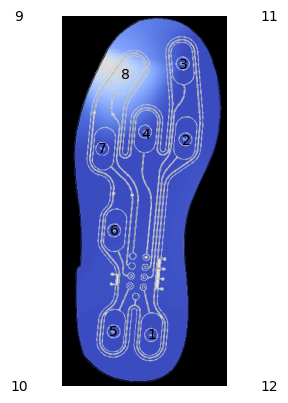

In [37]:

pressure_readings = np.array([0,0,0,0,0,0,0,1])

corner_pressures = np.zeros(4)
pressure_readings = np.concatenate([pressure_readings, corner_pressures])

interpolated_pressure_roi = griddata(sensor_locations_pixels_left, pressure_readings,
                                     (x_mesh_roi, y_mesh_roi), method='cubic')

for i, (x, y) in enumerate(sensor_locations_pixels_left):
    plt.text(x, y, str(i+1), color='black', ha='center', va='center')

plt.imshow(interpolated_pressure_roi, cmap='coolwarm', origin='lower', vmin=0.0, vmax=max_value,
           extent=(roi_left, roi_right, roi_top, roi_bottom))

plt.imshow(shoe_outline_left, extent=(roi_left, roi_right, roi_top, roi_bottom), alpha=1)

plt.axis("off")

plt.savefig(f'../Output/heatmap_first_left.png')



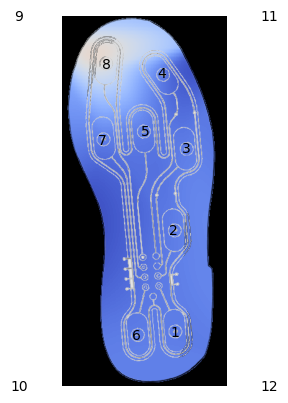

In [38]:

pressure_readings = np.array([0,0,0,0,0,0,0,1])

corner_pressures = np.zeros(4)
pressure_readings = np.concatenate([pressure_readings, corner_pressures])

interpolated_pressure_roi = griddata(sensor_locations_pixels_right, pressure_readings,
                                     (x_mesh_roi, y_mesh_roi), method='cubic')


for i, (x, y) in enumerate(sensor_locations_pixels_right):
    plt.text(x, y, str(i+1), color='black', ha='center', va='center')

plt.imshow(interpolated_pressure_roi, cmap='coolwarm', origin='lower', vmax=max_value, 
           extent=(roi_left, roi_right, roi_top, roi_bottom))

plt.imshow(shoe_outline_right, extent=(roi_left, roi_right, roi_top, roi_bottom), alpha=1)

plt.axis("off")

plt.savefig(f'../Output/heatmap_first_right.png')

# **Creating the Video**

In [39]:
output_video_path = output_path + 'heatmap_animation.mp4' 
frame_rate = 30
first_image = cv2.imread('../Output/heatmap_first_left.png')  
height, width, layers = first_image.shape
spacing = 225
video = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), frame_rate, ((width-spacing) * 2, height))


padding_width = 10

for index, row in combined_data_array.iterrows():
    
    data_left = row['data_array_left']
    data_right = row['data_array_right']
    
    interpolated_pressure_roi_left = griddata(sensor_locations_pixels_left, data_left,
                                              (x_mesh_roi, y_mesh_roi), method='cubic')
    
    interpolated_pressure_roi_right = griddata(sensor_locations_pixels_right, data_right,
                                               (x_mesh_roi, y_mesh_roi), method='cubic')
    

    plt.imshow(interpolated_pressure_roi_left, cmap='coolwarm', origin='lower', vmax=max_value,
               extent=(roi_left, roi_right, roi_top, roi_bottom))
    plt.imshow(shoe_outline_left, extent=(roi_left, roi_right, roi_top, roi_bottom), alpha=1)
    plt.axis("off")
    
    
    buf_left = io.BytesIO()
    plt.savefig(buf_left, format='png')
    buf_left.seek(0)
    heatmap_img_left = cv2.imdecode(np.frombuffer(buf_left.getvalue(), dtype=np.uint8), 1)
    buf_left.close()
    plt.close()
    
    heatmap_img_left_bgr = cv2.cvtColor(heatmap_img_left, cv2.COLOR_RGBA2BGR)
    
   
    plt.imshow(interpolated_pressure_roi_right, cmap='coolwarm', origin='lower', vmax=max_value,
               extent=(roi_left, roi_right, roi_top, roi_bottom))
    plt.imshow(shoe_outline_right, extent=(roi_left, roi_right, roi_top, roi_bottom), alpha=1)
    plt.axis("off")
    

    buf_right = io.BytesIO()
    plt.savefig(buf_right, format='png')
    buf_right.seek(0)
    heatmap_img_right = cv2.imdecode(np.frombuffer(buf_right.getvalue(), dtype=np.uint8), 1)
    buf_right.close()
    plt.close()
    
    heatmap_img_right_bgr = cv2.cvtColor(heatmap_img_right, cv2.COLOR_RGBA2BGR)

    heatmap_img_left = heatmap_img_left[:, :-spacing]
    heatmap_img_right = heatmap_img_right[:, spacing:]
    
    height = max(heatmap_img_left.shape[0], heatmap_img_right.shape[0])
    heatmap_img_left = cv2.resize(heatmap_img_left, (int(heatmap_img_left.shape[1] * height / heatmap_img_left.shape[0]), height))
    heatmap_img_right = cv2.resize(heatmap_img_right, (int(heatmap_img_right.shape[1] * height / heatmap_img_right.shape[0]), height))

    combined_image = cv2.hconcat([heatmap_img_left, heatmap_img_right])

    
    video.write(combined_image)

cv2.destroyAllWindows()
video.release()
print("Video created successfully.")


Video created successfully.
